In [1]:
from sklearn.feature_extraction.text import CountVectorizer
import spacy
import pandas as pd
import numpy as np 

In [3]:
nlp = spacy.load('en_core_web_sm')
def preprocess_text(text):
    doc = nlp(text)
    filtered_tokens = []
    for token in doc:
        if token.is_stop or token.is_punct:
            continue
        else:
            filtered_tokens.append(token.lemma_)
    return " ".join(filtered_tokens)

In [4]:
# Example
text = "The quick brown fox jumps over the lazy dog."
print(preprocess_text(text))

quick brown fox jump lazy dog


In [5]:
df = pd.read_json('news_dataset.json')
df.head()

,text,category
0,Watching Schrödinger's Cat Die University of C...,SCIENCE
1,WATCH: Freaky Vortex Opens Up In Flooded Lake,SCIENCE
2,Entrepreneurs Today Don't Need a Big Budget to...,BUSINESS
3,These Roads Could Recharge Your Electric Car A...,BUSINESS
4,Civilian 'Guard' Fires Gun While 'Protecting' ...,CRIME


In [6]:
df.category.value_counts()

category
BUSINESS    4254
SPORTS      4167
CRIME       2893
SCIENCE     1381
Name: count, dtype: int64

In [7]:
# Handle imbalanced dataset
min_samples = df.category.value_counts().min()
df = df.groupby('category').apply(lambda x: x.sample(min_samples)).reset_index(drop=True)
df.category.value_counts()

C:\Users\Gokuleshwaran\AppData\Local\Temp\ipykernel_21900\3735370689.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('category').apply(lambda x: x.sample(min_samples)).reset_index(drop=True)


category
BUSINESS    1381
CRIME       1381
SCIENCE     1381
SPORTS      1381
Name: count, dtype: int64

In [8]:
# Convert category to numerical
df['category_num'] = df['category'].map({
    'BUSINESS': 0,
    'SPORTS': 1, 
    'CRIME': 2, 
    'SCIENCE': 3
}) 

In [9]:
df.head()

,text,category,category_num
0,How Positivity Drives Productivity Whether you...,BUSINESS,0
1,Why Companies Should Respond When Twitter Rage...,BUSINESS,0
2,Costco Will Stop Accepting AmEx Cards Next Year,BUSINESS,0
3,(VIDEO) Heineken Taps TubeMogul for Programmat...,BUSINESS,0
4,New York Cracks Down On Payday Lenders,BUSINESS,0


In [10]:
df.category_num.value_counts()

category_num
0    1381
2    1381
3    1381
1    1381
Name: count, dtype: int64

In [17]:
df['preprocessed_text'] = df['text'].apply(preprocess_text)

In [18]:
df.head()

,text,category,category_num,preprocessed_text
0,How Positivity Drives Productivity Whether you...,BUSINESS,0,Positivity drive Productivity occasional chron...
1,Why Companies Should Respond When Twitter Rage...,BUSINESS,0,company respond Twitter rage spike clam thing bad
2,Costco Will Stop Accepting AmEx Cards Next Year,BUSINESS,0,Costco stop accept AmEx Cards Year
3,(VIDEO) Heineken Taps TubeMogul for Programmat...,BUSINESS,0,video Heineken Taps TubeMogul Programmatic Cam...
4,New York Cracks Down On Payday Lenders,BUSINESS,0,New York Cracks Payday lender


In [20]:
# Train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df['preprocessed_text'], df['category_num'], test_size=0.2, random_state=42, stratify=df['category_num'])

In [21]:
# Count Vectorizer
vectorizer = CountVectorizer(ngram_range=(1,1))
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

In [22]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
clf = MultinomialNB()
clf.fit(X_train_vectorized, y_train)
y_pred = clf.predict(X_test_vectorized)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.88      0.86       276
           1       0.91      0.92      0.92       276
           2       0.86      0.93      0.90       277
           3       0.92      0.80      0.86       276

    accuracy                           0.88      1105
   macro avg       0.89      0.88      0.88      1105
weighted avg       0.89      0.88      0.88      1105



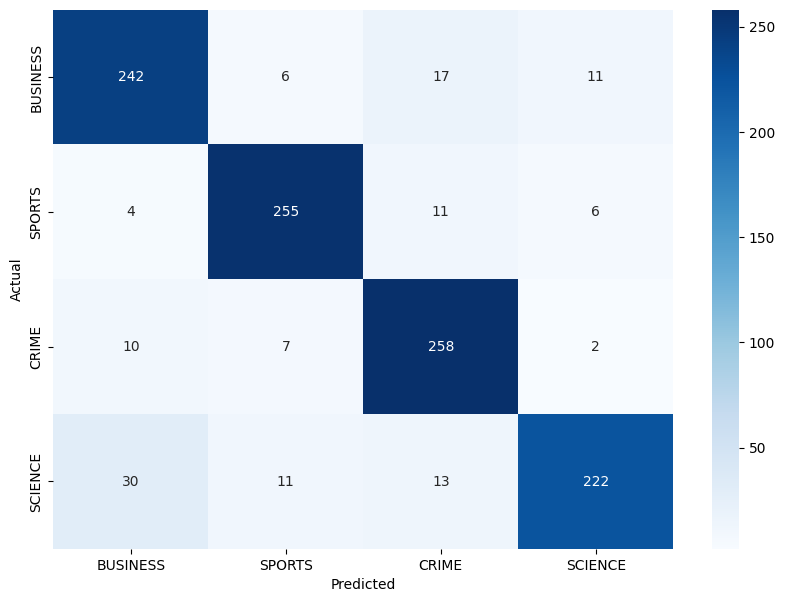

In [24]:
# confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 7))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', xticklabels=['BUSINESS', 'SPORTS', 'CRIME', 'SCIENCE'], yticklabels=['BUSINESS', 'SPORTS', 'CRIME', 'SCIENCE'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()